# Flight Delay prediction
As people increasingly choose to travel by air, the amount of flights that fail to take off on time also increases. This growth exacerbates the crowded situation at airports and causes financial difficulties within the airline industry. Air transportation delay indicates the lack of efficiency of the aviation system. It is a high cost to both airline companies and their passengers.

Predicting flight delays can improve airline operations and passenger satisfaction, which will result in a positive impact on the economy.

## Dataset
The dataset used for this analysis contains data about flights leaving from JFK airport between one year from `November 2019` to `December 2020`. It can be obtained from open data at https://www.kaggle.com/deepankurk/flight-take-off-data-jfk-airport. It includes 28820 lines of individual flight information with 23 columns. 

Any airline flights that departed or arrived 15 min late at their destination to be considered as delayed. Prediction of flight delays can be conducted on the variable `DEP_DELAY` (renamed as `IS_DELAYED`) by binary classification.

#### Attribute description for the dataset

Attribute Name | Description | Type
---------------|-------------|------
MONTH | Month | Integer
DAY_OF_MONTH | Date of flight | Integer
DAY_OF_WEEK | Day of the week | Integer
OP_UNIQUE_CARRIER | Carrier code that represents the carrier company | Object
TAIL_NUM | Air flight number | Object
DEST | Destination | Object
DEP_DELAY | Departure delay of the flight | Integer
CRS_ELAPSED_TIME | Scheduled journey time of the flight | Integer
DISTANCE | Distance of the flight | Integer
CRS_DEP_M | Scheduled departure time | Integer
DEP_TIME_M | Actual departure time | Integer
CRS_ARR_M | Scheduled arrival time | Integer
Temperature | Temperature | Integer
Dew Point | Dew Point | Object
Humidity | Humidity | Integer
Wind | Wind direction | Object
Wind Speed | Wind speed | Integer
Wind Gust | Wind gust | Integer
Pressure | Pressure | Floating Point
Condition | Condition of the climate | Object
sch_dep | Number of flights scheduled for departure | Integer
sch_arr | Number of flights scheduled for arrival | Integer
TAXI_OUT | Taxi-out time | Integer

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import opendatasets as od
from icecream import ic     # for debuging

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer

import bentoml
import json

In [2]:
# Download dataset
dataset_url = 'https://www.kaggle.com/datasets/deepankurk/flight-take-off-data-jfk-airport'
od.download(dataset_url)

## Data Cleaning and Preprocessing

In [3]:
pd.set_option('display.width', 1200)
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 200)

In [4]:
df = pd.read_csv('flight-take-off-data-jfk-airport/M1_final.csv')
df

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,DEP_TIME_M,CRS_ARR_M,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,323,448,48,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,333,531,48,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,341,482,48,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,343,513,48,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,356,499,46,32,58,W,24,35,29.91,Fair / Windy,9,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,1,31,5,B6,N216JB,ORH,2,57,150,1370,1372,1427,39,38,96,N,6,0,30.18,Cloudy,20,32,19
28816,1,31,5,AA,N104NN,BOS,2,75,187,1390,1392,25,39,38,96,N,6,0,30.18,Cloudy,19,23,22
28817,1,31,5,AS,N581AS,SEA,283,392,2422,1125,1408,1337,39,38,96,N,6,0,30.18,Cloudy,19,23,21
28818,1,31,5,B6,N957JB,SJU,5,224,1598,1417,1422,261,39,38,96,N,6,0,30.18,Cloudy,19,23,13


In [5]:
df.shape

(28820, 23)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  object 
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

Let's change few column names for better understanding

In [7]:
# change few column names
column_names = {"OP_UNIQUE_CARRIER":"CARRIER_CODE",
                "TAIL_NUM":"FLIGHT_NO",
                "CRS_ELAPSED_TIME":"SCHEDULED_DURATION",
                "CRS_DEP_M":"SCHEDULED_DEPARTURE",
                "DEP_TIME_M":"ACTUAL_DEP_TIME",
                "CRS_ARR_M":"SCHEDULED_ARRIVAL",
                "sch_dep":"FLT_SCH_ARRIVAL",
                "sch_arr":"FLT_SCH_DEPARTURE"
               }

df = df.rename(column_names, axis=1)

df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER_CODE,FLIGHT_NO,DEST,DEP_DELAY,SCHEDULED_DURATION,DISTANCE,SCHEDULED_DEPARTURE,ACTUAL_DEP_TIME,SCHEDULED_ARRIVAL,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,FLT_SCH_ARRIVAL,FLT_SCH_DEPARTURE,TAXI_OUT
0,11,1,5,B6,N828JB,CHS,-1,124,636,324,323,448,48,34,58,W,25,38,29.86,Fair / Windy,9,17,14
1,11,1,5,B6,N992JB,LAX,-7,371,2475,340,333,531,48,34,58,W,25,38,29.86,Fair / Windy,9,17,15
2,11,1,5,B6,N959JB,FLL,40,181,1069,301,341,482,48,34,58,W,25,38,29.86,Fair / Windy,9,17,22
3,11,1,5,B6,N999JQ,MCO,-2,168,944,345,343,513,48,34,58,W,25,38,29.86,Fair / Windy,9,17,12
4,11,1,5,DL,N880DN,ATL,-4,139,760,360,356,499,46,32,58,W,24,35,29.91,Fair / Windy,9,17,13


In [8]:
# Change column names and objects to lowercase, repalce sapces with _
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [9]:
df.head()

,month,day_of_month,day_of_week,carrier_code,flight_no,dest,dep_delay,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,condition,flt_sch_arrival,flt_sch_departure,taxi_out
0,11,1,5,b6,n828jb,chs,-1,124,636,324,323,448,48,34,58,w,25,38,29.86,fair_/_windy,9,17,14
1,11,1,5,b6,n992jb,lax,-7,371,2475,340,333,531,48,34,58,w,25,38,29.86,fair_/_windy,9,17,15
2,11,1,5,b6,n959jb,fll,40,181,1069,301,341,482,48,34,58,w,25,38,29.86,fair_/_windy,9,17,22
3,11,1,5,b6,n999jq,mco,-2,168,944,345,343,513,48,34,58,w,25,38,29.86,fair_/_windy,9,17,12
4,11,1,5,dl,n880dn,atl,-4,139,760,360,356,499,46,32,58,w,24,35,29.91,fair_/_windy,9,17,13


In [10]:
# Find null values
df.isnull().sum()

month                  0
day_of_month           0
day_of_week            0
carrier_code           0
flight_no              0
dest                   0
dep_delay              0
scheduled_duration     0
distance               0
scheduled_departure    0
actual_dep_time        0
scheduled_arrival      0
temperature            0
dew_point              0
humidity               0
wind                   2
wind_speed             0
wind_gust              0
pressure               0
condition              0
flt_sch_arrival        0
flt_sch_departure      0
taxi_out               0
dtype: int64

There were only `two` out of `28820` rows with missing values, which means that the deletion of those rows will have little effect on the overall data set distribution.

In [11]:
# Drop rows with missing values
df.dropna(inplace=True)
df

,month,day_of_month,day_of_week,carrier_code,flight_no,dest,dep_delay,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,condition,flt_sch_arrival,flt_sch_departure,taxi_out
0,11,1,5,b6,n828jb,chs,-1,124,636,324,323,448,48,34,58,w,25,38,29.86,fair_/_windy,9,17,14
1,11,1,5,b6,n992jb,lax,-7,371,2475,340,333,531,48,34,58,w,25,38,29.86,fair_/_windy,9,17,15
2,11,1,5,b6,n959jb,fll,40,181,1069,301,341,482,48,34,58,w,25,38,29.86,fair_/_windy,9,17,22
3,11,1,5,b6,n999jq,mco,-2,168,944,345,343,513,48,34,58,w,25,38,29.86,fair_/_windy,9,17,12
4,11,1,5,dl,n880dn,atl,-4,139,760,360,356,499,46,32,58,w,24,35,29.91,fair_/_windy,9,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,1,31,5,b6,n216jb,orh,2,57,150,1370,1372,1427,39,38,96,n,6,0,30.18,cloudy,20,32,19
28816,1,31,5,aa,n104nn,bos,2,75,187,1390,1392,25,39,38,96,n,6,0,30.18,cloudy,19,23,22
28817,1,31,5,as,n581as,sea,283,392,2422,1125,1408,1337,39,38,96,n,6,0,30.18,cloudy,19,23,21
28818,1,31,5,b6,n957jb,sju,5,224,1598,1417,1422,261,39,38,96,n,6,0,30.18,cloudy,19,23,13


In [12]:
# recheck for missing values again
df.isnull().sum()

month                  0
day_of_month           0
day_of_week            0
carrier_code           0
flight_no              0
dest                   0
dep_delay              0
scheduled_duration     0
distance               0
scheduled_departure    0
actual_dep_time        0
scheduled_arrival      0
temperature            0
dew_point              0
humidity               0
wind                   0
wind_speed             0
wind_gust              0
pressure               0
condition              0
flt_sch_arrival        0
flt_sch_departure      0
taxi_out               0
dtype: int64

In [13]:
df.head().T

,0,1,2,3,4
month,11,11,11,11,11
day_of_month,1,1,1,1,1
day_of_week,5,5,5,5,5
carrier_code,b6,b6,b6,b6,dl
flight_no,n828jb,n992jb,n959jb,n999jq,n880dn
dest,chs,lax,fll,mco,atl
dep_delay,-1,-7,40,-2,-4
scheduled_duration,124,371,181,168,139
distance,636,2475,1069,944,760
scheduled_departure,324,340,301,345,360


In [14]:
df.dew_point.value_counts()

33    1349
34    1156
30    1132
35    1124
32    1116
31    1070
24     931
27     862
25     847
39     843
28     816
29     759
23     751
45     697
26     686
37     678
42     671
46     651
18     600
38     600
20     544
41     534
22     525
21     520
43     511
36     507
40     499
44     469
16     447
51     442
15     429
48     420
8      371
47     361
52     318
13     314
9      305
19     303
17     296
14     289
50     274
5      249
49     247
12     242
7      235
54     226
53     212
11     180
10     145
3      138
4      133
6      130
-3     128
55     128
-2      81
0       75
-1      65
1       61
58      31
56      29
2       28
59      22
57      13
67       3
Name: dew_point, dtype: int64

In [15]:
df.dew_point.dtype

dtype('O')

change the variable “DEW_POINT” from `object` datatype to `integer` datatype since it has numerical values

In [16]:
# change dtype to int
df.dew_point = df.dew_point.astype('int64')

In [17]:
df.dtypes

month                    int64
day_of_month             int64
day_of_week              int64
carrier_code            object
flight_no               object
dest                    object
dep_delay                int64
scheduled_duration       int64
distance                 int64
scheduled_departure      int64
actual_dep_time          int64
scheduled_arrival        int64
temperature              int64
dew_point                int64
humidity                 int64
wind                    object
wind_speed               int64
wind_gust                int64
pressure               float64
condition               object
flt_sch_arrival          int64
flt_sch_departure        int64
taxi_out                 int64
dtype: object

In [18]:
df

,month,day_of_month,day_of_week,carrier_code,flight_no,dest,dep_delay,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,condition,flt_sch_arrival,flt_sch_departure,taxi_out
0,11,1,5,b6,n828jb,chs,-1,124,636,324,323,448,48,34,58,w,25,38,29.86,fair_/_windy,9,17,14
1,11,1,5,b6,n992jb,lax,-7,371,2475,340,333,531,48,34,58,w,25,38,29.86,fair_/_windy,9,17,15
2,11,1,5,b6,n959jb,fll,40,181,1069,301,341,482,48,34,58,w,25,38,29.86,fair_/_windy,9,17,22
3,11,1,5,b6,n999jq,mco,-2,168,944,345,343,513,48,34,58,w,25,38,29.86,fair_/_windy,9,17,12
4,11,1,5,dl,n880dn,atl,-4,139,760,360,356,499,46,32,58,w,24,35,29.91,fair_/_windy,9,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,1,31,5,b6,n216jb,orh,2,57,150,1370,1372,1427,39,38,96,n,6,0,30.18,cloudy,20,32,19
28816,1,31,5,aa,n104nn,bos,2,75,187,1390,1392,25,39,38,96,n,6,0,30.18,cloudy,19,23,22
28817,1,31,5,as,n581as,sea,283,392,2422,1125,1408,1337,39,38,96,n,6,0,30.18,cloudy,19,23,21
28818,1,31,5,b6,n957jb,sju,5,224,1598,1417,1422,261,39,38,96,n,6,0,30.18,cloudy,19,23,13


In [19]:
# check value counts of dep_depay
df.dep_delay.value_counts()

-5       2899
-4       2476
-3       2300
-6       2169
-2       2018
         ... 
 1048       1
 320        1
 233        1
 374        1
 145        1
Name: dep_delay, Length: 342, dtype: int64

In [20]:
df.describe().round(2)

,month,day_of_month,day_of_week,dep_delay,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,flt_sch_arrival,flt_sch_departure,taxi_out
count,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00,28818.00
mean,7.89,16.02,4.01,6.37,225.29,1267.79,830.97,828.90,910.89,41.49,30.42,57.73,12.37,5.54,30.09,31.09,28.43,20.86
std,4.99,8.75,1.99,38.74,119.48,889.35,299.38,305.84,345.37,8.04,12.31,23.47,6.26,11.89,0.30,9.51,8.26,6.85
min,1.00,1.00,1.00,-22.00,57.00,94.00,301.00,1.00,1.00,17.00,-3.00,0.00,0.00,0.00,29.20,0.00,0.00,5.00
25%,1.00,8.00,2.00,-6.00,124.00,483.00,545.00,542.00,667.00,36.00,23.00,46.00,8.00,0.00,29.88,26.00,21.00,16.00
50%,11.00,16.00,4.00,-3.00,188.00,1029.00,856.00,854.00,918.00,42.00,31.00,59.00,12.00,0.00,30.11,30.00,30.00,19.00
75%,12.00,24.00,6.00,2.00,365.00,2248.00,1095.00,1097.00,1192.75,47.00,39.00,74.00,16.00,0.00,30.32,37.00,35.00,25.00
max,12.00,31.00,7.00,1276.00,697.00,4983.00,1439.00,1440.00,1439.00,68.00,67.00,97.00,36.00,49.00,30.75,55.00,46.00,41.00


`dep_delay` values have anomally - mean is 6.37 whereas std is 38.74

- Convert 'dep_delay' into bianry 0 and 1  -- above 15 minutes is 1, below is 0
- Create column 'is_delayed' as target
- Drop 'flight_no' column as tail number do not have anything to do with flight delays

In [21]:
# convert 'dep_delay' into bianry 0 and 1  -- above 15 minutes is 1, below is 0
df_processed = df.copy()
df_processed

,month,day_of_month,day_of_week,carrier_code,flight_no,dest,dep_delay,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,condition,flt_sch_arrival,flt_sch_departure,taxi_out
0,11,1,5,b6,n828jb,chs,-1,124,636,324,323,448,48,34,58,w,25,38,29.86,fair_/_windy,9,17,14
1,11,1,5,b6,n992jb,lax,-7,371,2475,340,333,531,48,34,58,w,25,38,29.86,fair_/_windy,9,17,15
2,11,1,5,b6,n959jb,fll,40,181,1069,301,341,482,48,34,58,w,25,38,29.86,fair_/_windy,9,17,22
3,11,1,5,b6,n999jq,mco,-2,168,944,345,343,513,48,34,58,w,25,38,29.86,fair_/_windy,9,17,12
4,11,1,5,dl,n880dn,atl,-4,139,760,360,356,499,46,32,58,w,24,35,29.91,fair_/_windy,9,17,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,1,31,5,b6,n216jb,orh,2,57,150,1370,1372,1427,39,38,96,n,6,0,30.18,cloudy,20,32,19
28816,1,31,5,aa,n104nn,bos,2,75,187,1390,1392,25,39,38,96,n,6,0,30.18,cloudy,19,23,22
28817,1,31,5,as,n581as,sea,283,392,2422,1125,1408,1337,39,38,96,n,6,0,30.18,cloudy,19,23,21
28818,1,31,5,b6,n957jb,sju,5,224,1598,1417,1422,261,39,38,96,n,6,0,30.18,cloudy,19,23,13


In [22]:
df_processed['is_delayed'] = df_processed['dep_delay'].map(lambda x: 1 if x >= 15 else 0)
df_processed['is_delayed']

0        0
1        0
2        1
3        0
4        0
        ..
28815    0
28816    0
28817    1
28818    0
28819    0
Name: is_delayed, Length: 28818, dtype: int64

In [23]:
df_processed = df_processed.drop('dep_delay', axis=1)
df_processed = df_processed.drop('flight_no', axis=1)
df_processed

,month,day_of_month,day_of_week,carrier_code,dest,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,condition,flt_sch_arrival,flt_sch_departure,taxi_out,is_delayed
0,11,1,5,b6,chs,124,636,324,323,448,48,34,58,w,25,38,29.86,fair_/_windy,9,17,14,0
1,11,1,5,b6,lax,371,2475,340,333,531,48,34,58,w,25,38,29.86,fair_/_windy,9,17,15,0
2,11,1,5,b6,fll,181,1069,301,341,482,48,34,58,w,25,38,29.86,fair_/_windy,9,17,22,1
3,11,1,5,b6,mco,168,944,345,343,513,48,34,58,w,25,38,29.86,fair_/_windy,9,17,12,0
4,11,1,5,dl,atl,139,760,360,356,499,46,32,58,w,24,35,29.91,fair_/_windy,9,17,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,1,31,5,b6,orh,57,150,1370,1372,1427,39,38,96,n,6,0,30.18,cloudy,20,32,19,0
28816,1,31,5,aa,bos,75,187,1390,1392,25,39,38,96,n,6,0,30.18,cloudy,19,23,22,0
28817,1,31,5,as,sea,392,2422,1125,1408,1337,39,38,96,n,6,0,30.18,cloudy,19,23,21,1
28818,1,31,5,b6,sju,224,1598,1417,1422,261,39,38,96,n,6,0,30.18,cloudy,19,23,13,0


In [24]:
df_processed.is_delayed.value_counts()

0    24798
1     4020
Name: is_delayed, dtype: int64

In [25]:
df_processed.is_delayed.value_counts(normalize=True)

0    0.860504
1    0.139496
Name: is_delayed, dtype: float64

Dataset is imbalanced

## Split the data

* Split data in train/val/test sets, with 60%/20%/20% distribution.
* Use stratify option to reduce imbalance

In [26]:
# Train-val-test split
df_full_train, df_test = train_test_split(df_processed, stratify=df_processed['is_delayed'], test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, stratify=df_full_train['is_delayed'], test_size=0.25, random_state=42)
len(df_train), len(df_val), len(df_test)

(17290, 5764, 5764)

In [27]:
print(df_train.is_delayed.value_counts())
print(df_val.is_delayed.value_counts())
print(df_test.is_delayed.value_counts())

0    14878
1     2412
Name: is_delayed, dtype: int64
0    4960
1     804
Name: is_delayed, dtype: int64
0    4960
1     804
Name: is_delayed, dtype: int64


In [28]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [29]:
df_train

,month,day_of_month,day_of_week,carrier_code,dest,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,condition,flt_sch_arrival,flt_sch_departure,taxi_out,is_delayed
0,1,16,4,b6,jax,161,828,869,876,1030,39,33,79,wnw,29,38,29.94,light_rain_/_windy,27,38,39,0
1,12,28,6,dl,stt,232,1623,515,513,807,47,42,83,nw,10,0,30.21,partly_cloudy,50,20,26,0
2,12,25,3,b6,mco,187,944,480,500,667,36,27,70,n,7,0,30.25,partly_cloudy,47,16,18,1
3,12,25,3,aa,lax,398,2475,540,536,758,39,28,65,ne,8,0,30.25,mostly_cloudy,47,16,26,0
4,1,2,4,dl,fll,196,1069,485,482,681,37,28,70,sw,7,0,29.99,fair,50,19,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,1,31,5,yx,dca,86,213,709,697,795,42,34,73,ese,8,0,30.32,mostly_cloudy,28,18,21,0
17286,12,24,2,b6,oak,404,2576,1120,1144,1344,39,24,55,n,10,0,30.17,mostly_cloudy,35,26,24,1
17287,11,28,4,b6,lax,376,2475,480,471,676,49,33,54,wnw,21,33,29.76,mostly_cloudy_/_windy,32,22,15,0
17288,12,12,4,b6,atl,160,760,921,915,1081,33,13,43,s,7,0,30.70,mostly_cloudy,30,36,11,0


In [30]:
y_train = df_train['is_delayed'].values
y_val = df_val['is_delayed'].values
y_test = df_test['is_delayed'].values

In [31]:
y_train

array([0, 0, 1, ..., 0, 0, 0])

## EDA

In [32]:
df_full_train.is_delayed.value_counts()

0    19838
1     3216
Name: is_delayed, dtype: int64

<AxesSubplot:xlabel='is_delayed', ylabel='Count'>

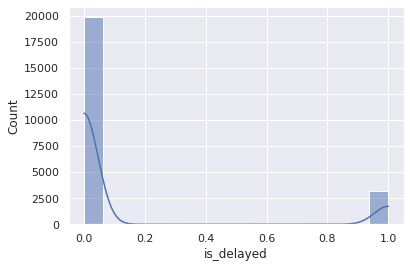

In [33]:
#  create histplot for 'is_delayed' column
sns.histplot(data=df_full_train, x='is_delayed', kde=True)

In [34]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28818 entries, 0 to 28819
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                28818 non-null  int64  
 1   day_of_month         28818 non-null  int64  
 2   day_of_week          28818 non-null  int64  
 3   carrier_code         28818 non-null  object 
 4   dest                 28818 non-null  object 
 5   scheduled_duration   28818 non-null  int64  
 6   distance             28818 non-null  int64  
 7   scheduled_departure  28818 non-null  int64  
 8   actual_dep_time      28818 non-null  int64  
 9   scheduled_arrival    28818 non-null  int64  
 10  temperature          28818 non-null  int64  
 11  dew_point            28818 non-null  int64  
 12  humidity             28818 non-null  int64  
 13  wind                 28818 non-null  object 
 14  wind_speed           28818 non-null  int64  
 15  wind_gust            28818 non-null 

In [35]:
categorical_columns = ['carrier_code', 'dest', 'wind', 'condition']
categorical_columns

['carrier_code', 'dest', 'wind', 'condition']

- Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of train dataset.
- In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

In [36]:
df_train_numeric = df_train.copy()
# print(df_train_numeric.dtypes)
# drop categorical columns
df_train_numeric = df_train_numeric.drop(columns=categorical_columns, axis=1)
print(df_train_numeric.dtypes)
# Summary of numerical attributes for continuous variables
df_train_numeric.describe().round()

month                    int64
day_of_month             int64
day_of_week              int64
scheduled_duration       int64
distance                 int64
scheduled_departure      int64
actual_dep_time          int64
scheduled_arrival        int64
temperature              int64
dew_point                int64
humidity                 int64
wind_speed               int64
wind_gust                int64
pressure               float64
flt_sch_arrival          int64
flt_sch_departure        int64
taxi_out                 int64
is_delayed               int64
dtype: object


,month,day_of_month,day_of_week,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,flt_sch_arrival,flt_sch_departure,taxi_out,is_delayed
count,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0,17290.0
mean,8.0,16.0,4.0,225.0,1265.0,829.0,828.0,912.0,42.0,30.0,58.0,12.0,6.0,30.0,31.0,28.0,21.0,0.0
std,5.0,9.0,2.0,119.0,883.0,299.0,305.0,344.0,8.0,12.0,23.0,6.0,12.0,0.0,10.0,8.0,7.0,0.0
min,1.0,1.0,1.0,57.0,94.0,301.0,1.0,1.0,17.0,-3.0,0.0,0.0,0.0,29.0,0.0,0.0,7.0,0.0
25%,1.0,8.0,2.0,124.0,483.0,542.0,542.0,667.0,36.0,23.0,46.0,8.0,0.0,30.0,26.0,21.0,16.0,0.0
50%,11.0,16.0,4.0,188.0,1029.0,855.0,851.0,917.0,42.0,31.0,59.0,12.0,0.0,30.0,30.0,30.0,19.0,0.0
75%,12.0,24.0,6.0,364.0,2248.0,1095.0,1097.0,1193.0,47.0,39.0,75.0,16.0,0.0,30.0,38.0,35.0,25.0,0.0
max,12.0,31.0,7.0,697.0,4983.0,1439.0,1440.0,1439.0,68.0,67.0,97.0,36.0,49.0,31.0,55.0,46.0,41.0,1.0


In [37]:
corrM = df_train_numeric.corr()
corrM = round(corrM, 2)
corrM

,month,day_of_month,day_of_week,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,flt_sch_arrival,flt_sch_departure,taxi_out,is_delayed
month,1.00,0.00,0.03,-0.02,0.00,0.01,0.01,-0.01,0.14,0.13,0.01,-0.03,-0.05,-0.09,-0.01,-0.02,0.01,0.07
day_of_month,0.00,1.00,-0.03,0.00,-0.00,-0.00,-0.00,0.00,-0.13,-0.04,0.10,-0.10,-0.09,0.02,-0.00,-0.00,-0.02,-0.03
day_of_week,0.03,-0.03,1.00,0.01,0.01,0.01,0.01,-0.01,0.01,-0.08,-0.00,0.09,0.12,0.12,0.02,0.01,0.03,0.01
scheduled_duration,-0.02,0.00,0.01,1.00,0.99,-0.03,-0.02,0.04,-0.02,0.01,0.02,-0.01,-0.01,0.00,0.08,-0.07,0.07,-0.03
distance,0.00,-0.00,0.01,0.99,1.00,-0.04,-0.04,0.01,-0.01,0.01,0.02,-0.01,-0.01,-0.00,0.06,-0.09,0.06,-0.03
scheduled_departure,0.01,-0.00,0.01,-0.03,-0.04,1.00,0.95,0.47,0.09,0.00,-0.01,0.00,-0.01,-0.00,-0.01,0.50,0.05,0.12
actual_dep_time,0.01,-0.00,0.01,-0.02,-0.04,0.95,1.00,0.48,0.10,0.01,-0.02,0.00,-0.02,-0.00,0.03,0.54,0.06,0.13
scheduled_arrival,-0.01,0.00,-0.01,0.04,0.01,0.47,0.48,1.00,0.10,0.00,-0.03,0.01,-0.00,-0.01,0.15,0.42,0.07,0.05
temperature,0.14,-0.13,0.01,-0.02,-0.01,0.09,0.10,0.10,1.00,0.79,0.07,0.01,-0.05,-0.37,-0.03,0.08,-0.07,-0.02
dew_point,0.13,-0.04,-0.08,0.01,0.01,0.00,0.01,0.00,0.79,1.00,0.21,-0.15,-0.17,-0.48,0.01,0.00,0.00,-0.00


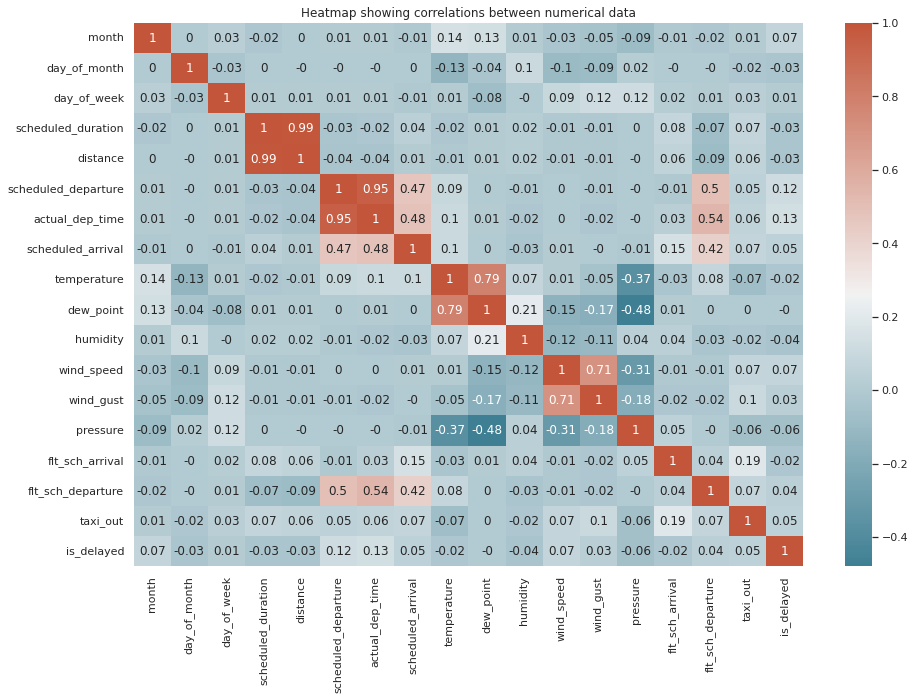

In [38]:
# sns plot for correlation matrix
plt.subplots(figsize=(15,10))
sns.heatmap(corrM, xticklabels=corrM.columns, yticklabels=corrM.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Heatmap showing correlations between numerical data')
plt.show()

In [39]:
df_train_numeric.corr().unstack().sort_values(ascending = False).head(25)

month                month                  1.000000
dew_point            dew_point              1.000000
scheduled_duration   scheduled_duration     1.000000
distance             distance               1.000000
scheduled_departure  scheduled_departure    1.000000
actual_dep_time      actual_dep_time        1.000000
scheduled_arrival    scheduled_arrival      1.000000
temperature          temperature            1.000000
humidity             humidity               1.000000
day_of_month         day_of_month           1.000000
wind_speed           wind_speed             1.000000
wind_gust            wind_gust              1.000000
pressure             pressure               1.000000
flt_sch_arrival      flt_sch_arrival        1.000000
flt_sch_departure    flt_sch_departure      1.000000
taxi_out             taxi_out               1.000000
day_of_week          day_of_week            1.000000
is_delayed           is_delayed             1.000000
distance             scheduled_duration     0.

- `scheduled_duration` and `distance` have highest corelation.
- `scheduled_departure` and `actual_dep_time` have 2nd highest corelation.

/home/ranga/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_delayed', ylabel='count'>

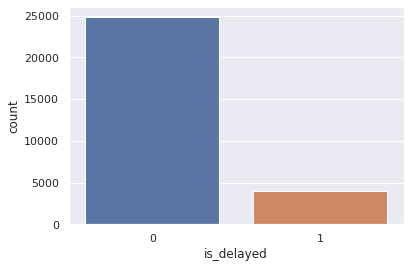

In [40]:
# countplots
sns.countplot(df_processed['is_delayed'])

/home/ranga/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='carrier_code', ylabel='count'>

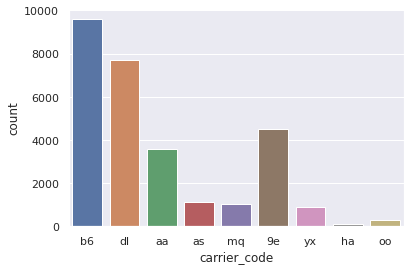

In [41]:
sns.countplot(df_processed['carrier_code'])

In [42]:
categorical_columns

['carrier_code', 'dest', 'wind', 'condition']

/home/ranga/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='wind', ylabel='count'>

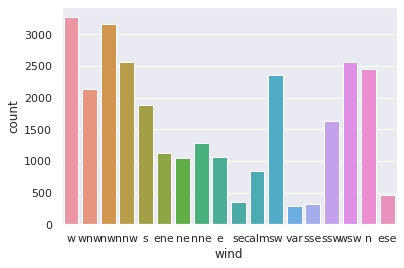

In [43]:
sns.countplot(df_processed['wind']) 

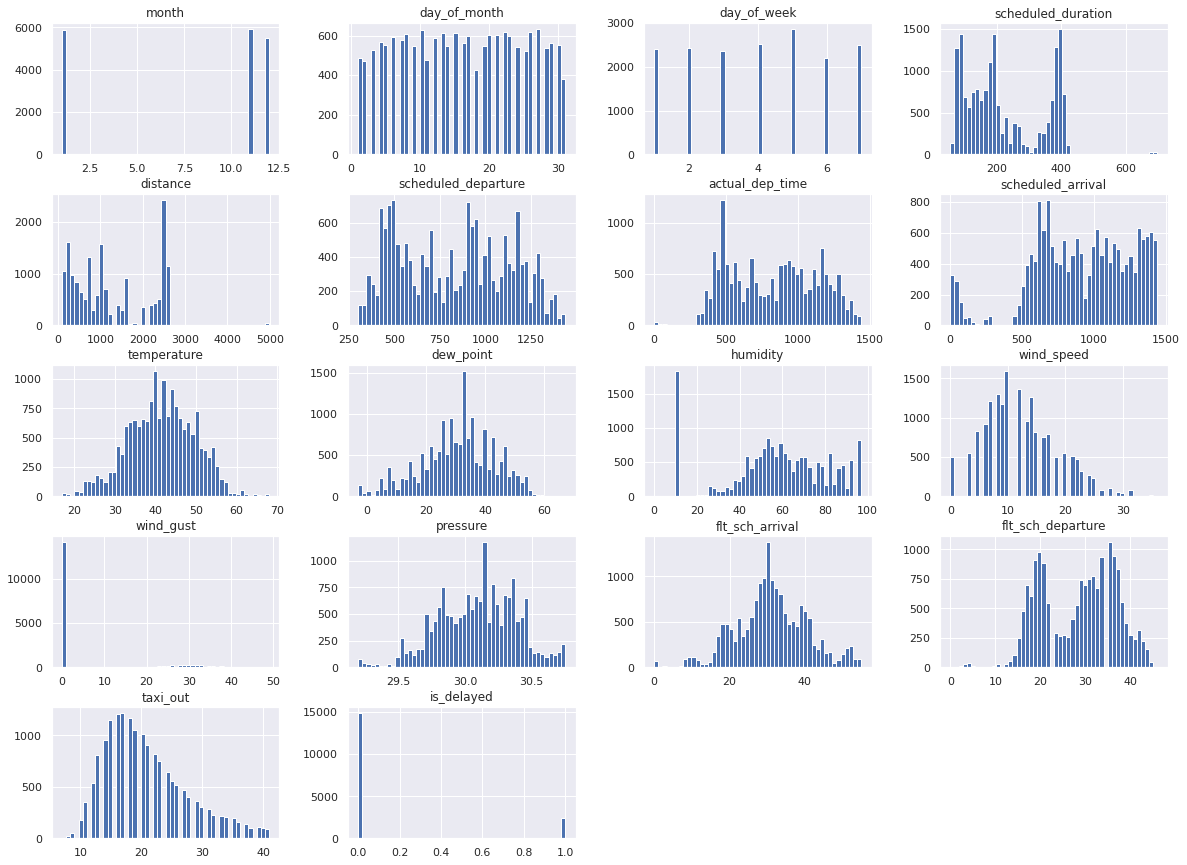

In [44]:
#Plot histograms of numerical data
df_train_numeric.hist(bins=50, figsize=(20, 15))
plt.show()

## Build models and tune parameters

1. 1 hot encoding with DictVectorizer
2. Logistic regression model
3. Decision Tree model
4. Grid search for parameter tuning
5. Random Forest model
6. XGBoost model
7. Train final model

In [45]:
# drop 'is_delayed' from datasets
df_train = df_train.drop('is_delayed', axis=1)
df_val = df_val.drop('is_delayed', axis=1)
df_test = df_test.drop('is_delayed', axis=1)

In [46]:
df_train

,month,day_of_month,day_of_week,carrier_code,dest,scheduled_duration,distance,scheduled_departure,actual_dep_time,scheduled_arrival,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,condition,flt_sch_arrival,flt_sch_departure,taxi_out
0,1,16,4,b6,jax,161,828,869,876,1030,39,33,79,wnw,29,38,29.94,light_rain_/_windy,27,38,39
1,12,28,6,dl,stt,232,1623,515,513,807,47,42,83,nw,10,0,30.21,partly_cloudy,50,20,26
2,12,25,3,b6,mco,187,944,480,500,667,36,27,70,n,7,0,30.25,partly_cloudy,47,16,18
3,12,25,3,aa,lax,398,2475,540,536,758,39,28,65,ne,8,0,30.25,mostly_cloudy,47,16,26
4,1,2,4,dl,fll,196,1069,485,482,681,37,28,70,sw,7,0,29.99,fair,50,19,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,1,31,5,yx,dca,86,213,709,697,795,42,34,73,ese,8,0,30.32,mostly_cloudy,28,18,21
17286,12,24,2,b6,oak,404,2576,1120,1144,1344,39,24,55,n,10,0,30.17,mostly_cloudy,35,26,24
17287,11,28,4,b6,lax,376,2475,480,471,676,49,33,54,wnw,21,33,29.76,mostly_cloudy_/_windy,32,22,15
17288,12,12,4,b6,atl,160,760,921,915,1081,33,13,43,s,7,0,30.70,mostly_cloudy,30,36,11


In [47]:
df_train.dtypes

month                    int64
day_of_month             int64
day_of_week              int64
carrier_code            object
dest                    object
scheduled_duration       int64
distance                 int64
scheduled_departure      int64
actual_dep_time          int64
scheduled_arrival        int64
temperature              int64
dew_point                int64
humidity                 int64
wind                    object
wind_speed               int64
wind_gust                int64
pressure               float64
condition               object
flt_sch_arrival          int64
flt_sch_departure        int64
taxi_out                 int64
dtype: object

In [48]:
df_train.columns

Index(['month', 'day_of_month', 'day_of_week', 'carrier_code', 'dest', 'scheduled_duration', 'distance', 'scheduled_departure', 'actual_dep_time', 'scheduled_arrival', 'temperature', 'dew_point', 'humidity', 'wind', 'wind_speed', 'wind_gust', 'pressure', 'condition', 'flt_sch_arrival', 'flt_sch_departure', 'taxi_out'], dtype='object')

In [49]:
numerical_columns = ['month', 'day_of_month', 'day_of_week', 'scheduled_duration', 'distance', 'scheduled_departure', 'actual_dep_time', 'scheduled_arrival', 'temperature', 'dew_point', 'humidity', 'wind_speed', 'wind_gust', 'pressure', 'flt_sch_arrival', 'flt_sch_departure', 'taxi_out']

In [50]:
ic(len(numerical_columns), len(categorical_columns))

ic| len(numerical_columns): 17, len(categorical_columns): 4


(17, 4)

### 1 hot encoding with DictVectorizer

In [51]:
# one hot encoding
train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.fit_transform(train_dict)

In [52]:
train_dict[:1]

[{'carrier_code': 'b6',
  'dest': 'jax',
  'wind': 'wnw',
  'condition': 'light_rain_/_windy',
  'month': 1,
  'day_of_month': 16,
  'day_of_week': 4,
  'scheduled_duration': 161,
  'distance': 828,
  'scheduled_departure': 869,
  'actual_dep_time': 876,
  'scheduled_arrival': 1030,
  'temperature': 39,
  'dew_point': 33,
  'humidity': 79,
  'wind_speed': 29,
  'wind_gust': 38,
  'pressure': 29.94,
  'flt_sch_arrival': 27,
  'flt_sch_departure': 38,
  'taxi_out': 39}]

In [53]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical_columns + numerical_columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

### Logistic regression model

In [54]:
# Logistic regression model
lr_model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_val)

lr_accuracy = np.round(accuracy_score(y_val, y_pred),5)
lr_precision = np.round(precision_score(y_val, y_pred, average='weighted'),5)
lr_recall = np.round(recall_score(y_val, y_pred, average='weighted'),5)
lr_f1 = np.round(f1_score(y_val, y_pred, average='weighted'),5)
lr_roc_auc = np.round(roc_auc_score(y_val, y_pred),5)

print("Logistic Regression Accuracy: ", lr_accuracy)
print("Logistic Regression Precision: ", lr_precision)
print("Logistic Regression Recall: ", lr_recall)
print("Logistic Regression F1_score: ", lr_f1)
print("Logistic Regression roc_auc_score: ", lr_roc_auc)

# ic(lr_accuracy)

Logistic Regression Accuracy:  0.86641
Logistic Regression Precision:  0.87724
Logistic Regression Recall:  0.86641
Logistic Regression F1_score:  0.81044
Logistic Regression roc_auc_score:  0.52219


In [55]:
lr_model.coef_[0].round(3)

array([ 0.006, -0.47 , -0.091,  0.373,  0.57 ,  0.002,  0.094, -0.024,
       -0.033, -0.411, -0.074, -0.009, -0.005,  0.007, -0.028, -0.08 ,
        0.074,  0.118, -0.003, -0.021, -0.032,  0.015, -0.051, -0.37 ,
       -0.015,  0.029, -0.076, -0.065,  0.022,  0.279,  0.286, -0.039,
        0.074, -0.025, -0.01 ,  0.018, -0.099,  0.029, -0.063, -0.014,
        0.097,  0.179,  0.351, -0.198,  0.094,  0.353, -0.26 ,  0.103,
       -0.186, -0.115, -0.081, -0.021,  0.009,  0.292, -0.089,  0.058,
        0.13 ,  0.189, -0.053,  0.248,  0.058,  0.027, -0.107, -0.226,
       -0.351, -0.023, -0.101,  0.046,  0.096, -0.058, -0.124,  0.093,
        0.004,  0.085, -0.055,  0.085, -0.028, -0.015,  0.004, -0.027,
        0.091, -0.034, -0.056, -0.137, -0.039, -0.113,  0.148, -0.109,
       -0.158, -0.087,  0.124, -0.149, -0.009,  0.047,  0.516, -0.071,
        0.055,  0.105,  0.031, -0.183, -0.303,  0.022, -0.002, -0.01 ,
       -0.019, -0.005,  0.044, -0.091,  0.   , -0.005,  0.015,  0.014,
      

In [56]:
# Predict on the test data

y_pred = lr_model.predict(X_test)
lr_accuracy = np.round(accuracy_score(y_test, y_pred),5)
print(lr_accuracy)

# Score our model
print('Logistic Regression Accuracy score: ', format(accuracy_score(y_test, y_pred)))
print('Logistic Regression Precision score: ', format(precision_score(y_test, y_pred)))
print('Logistic Regression Recall score: ', format(recall_score(y_test, y_pred)))
print('Logistic Regression F1 score: ', format(f1_score(y_test, y_pred)))
print('Logistic Regression roc_auc_score: ', format(roc_auc_score(y_test, y_pred)))

0.86745
Logistic Regression Accuracy score:  0.8674531575294934
Logistic Regression Precision score:  0.9761904761904762
Logistic Regression Recall score:  0.05099502487562189
Logistic Regression F1 score:  0.09692671394799054
Logistic Regression roc_auc_score:  0.525396705986198


In [57]:
y_pred = lr_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7395223980901942

### Decision Tree model

In [58]:
# Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=4,
                                min_samples_leaf=6,
                                min_samples_split=4,
                                random_state=1
                                )
                            
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_val)

dt_accuracy = np.round(accuracy_score(y_val, y_pred),5)
dt_precision = np.round(precision_score(y_val, y_pred),5)
dt_recall = np.round(recall_score(y_val, y_pred),5)
dt_f1 = np.round(f1_score(y_val, y_pred),5)
dt_roc_auc = np.round(roc_auc_score(y_val, y_pred),5)

print("Decision Tree Accuracy: ", dt_accuracy)
print("Decision Tree Precision: ", dt_precision)
print("Decision Tree Recall: ", dt_recall)
print("Decision Tree F1_score: ", dt_f1)
print("Decision Tree roc_auc_score: ", dt_roc_auc)

Decision Tree Accuracy:  0.87717
Decision Tree Precision:  0.9898
Decision Tree Recall:  0.12065
Decision Tree F1_score:  0.21508
Decision Tree roc_auc_score:  0.56022


In [59]:
# Predict on the test data

y_pred = dt_model.predict(X_test)
dt_accuracy = np.round(accuracy_score(y_test, y_pred),5)
print(dt_accuracy)

# Score our model
print('Decision Tree Accuracy score: ', format(accuracy_score(y_test, y_pred)))
print('Decision Tree Precision score: ', format(precision_score(y_test, y_pred)))
print('Decision Tree Recall score: ', format(recall_score(y_test, y_pred)))
print('Decision Tree F1 score: ', format(f1_score(y_test, y_pred)))
print('Decision Tree roc_auc_score: ', format(roc_auc_score(y_test, y_pred)))

0.87752
Decision Tree Accuracy score:  0.8775156141568355
Decision Tree Precision score:  0.99
Decision Tree Recall score:  0.12313432835820895
Decision Tree F1 score:  0.21902654867256638
Decision Tree roc_auc_score:  0.5614663577274915


### Now, Let's use grid search to see if we can improve this model further

1. First define some parameters to perform grid search on
2. Make a scorer for the model using `roc_auc_score`.
3. Perform grid search on the classifier, using the parameters and the scorer.
4. Fit the data to the new classifier.
5. Find the roc_auc_score.
6. If the model is not much better, try changing the ranges for the parameters and fit it again.
7. Put the steps 2-6 mentioned above inside a function `calculate_roc_auc_score(parameters)` 

In [60]:
dt_model = DecisionTreeClassifier(random_state=42)

#  Create the parameters list you wish to tune.
parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}

def calculate_roc_auc_score(parameters):
    #  Make an roc_auc_score scoring object.
    scorer = make_scorer(roc_auc_score)

    #  Perform grid search on the classifier using 'scorer' as the scoring method.
    grid_obj = GridSearchCV(dt_model, parameters, scoring=scorer)

    #  Fit the grid search object to the training data and find the optimal parameters.
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator.
    best_dt_model = grid_fit.best_estimator_

    # Fit the new model.
    best_dt_model.fit(X_train, y_train)

    # Make predictions using the new model.
    best_train_predictions = best_dt_model.predict(X_train)
    best_val_predictions = best_dt_model.predict(X_val)
    best_test_predictions = best_dt_model.predict(X_test)

    # Calculate the roc_auc_score of the new model.
    print('The training roc_auc_core is', roc_auc_score(best_train_predictions, y_train))
    print('The val roc_auc_core is', roc_auc_score(best_val_predictions, y_val))
    print('The testing roc_auc_core is', roc_auc_score(best_test_predictions, y_test))
 
    # Let's also explore what parameters ended up being used in the new model.
    print('\n')
    print('Best dt_model trained:', best_dt_model)
    print('\n')
    print('Best dt_model gridCV optimized parameters:',best_dt_model.get_params())

#----------------------------------------------#

# Call the function
calculate_roc_auc_score(parameters)

The training roc_auc_core is 0.943550435389323
The val roc_auc_core is 0.9324810785196951
The testing roc_auc_core is 0.9245224105898182


Best dt_model trained: DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)


Best dt_model gridCV optimized parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


### Random Forest model

In [61]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=4,
                            min_samples_split=10,
                            random_state=1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_val)

rf_accuracy = np.round(accuracy_score(y_val, y_pred),5)
rf_precision = np.round(precision_score(y_val, y_pred),5)
rf_recall = np.round(recall_score(y_val, y_pred),5)
rf_f1 = np.round(f1_score(y_val, y_pred),5)
rf_roc_auc = np.round(roc_auc_score(y_val, y_pred),5)

print("Random Forest Accuracy: ", rf_accuracy)
print("Random Forest Precision: ", rf_precision)
print("Random Forest Recall: ", rf_recall)
print("Random Forest F1_score: ", rf_f1)
print("Random Forest roc_auc_score: ", rf_roc_auc)

Random Forest Accuracy:  0.86867
Random Forest Precision:  0.96078
Random Forest Recall:  0.06095
Random Forest F1_score:  0.11462
Random Forest roc_auc_score:  0.53027


In [62]:
# Predict on the test data

y_pred = rf_model.predict(X_test)
rf_accuracy = np.round(accuracy_score(y_test, y_pred),5)
print(rf_accuracy)

# Score our model
print('Random Forest Accuracy score: ', format(accuracy_score(y_test, y_pred)))
print('Random Forest Precision score: ', format(precision_score(y_test, y_pred)))
print('Random Forest Recall score: ', format(recall_score(y_test, y_pred)))
print('Random Forest F1 score: ', format(f1_score(y_test, y_pred)))
print('Random Forest roc_auc_score: ', format(roc_auc_score(y_test, y_pred)))

0.86797
Random Forest Accuracy score:  0.8679736294240111
Random Forest Precision score:  0.9387755102040817
Random Forest Recall score:  0.05721393034825871
Random Forest F1 score:  0.10785463071512309
Random Forest roc_auc_score:  0.5283045458192906


In [63]:
y_pred = rf_model.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8004187730701331

### XGBoost model

In [64]:
# XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=175)

y_pred = xgb_model.predict(dtrain)
xgb_roc_auc = np.round(roc_auc_score(y_train, y_pred),5)
print("Train: xgb_model roc_auc_score: ", xgb_roc_auc)

y_pred = xgb_model.predict(dval)
xgb_roc_auc = np.round(roc_auc_score(y_val, y_pred),5)
print("Val: xgb_model roc_auc_score: ", xgb_roc_auc)

y_pred = xgb_model.predict(dtest)
xgb_roc_auc = np.round(roc_auc_score(y_test, y_pred),5)
print("Test: xgb_model roc_auc_score: ", xgb_roc_auc)

Train: xgb_model roc_auc_score:  0.99181
Val: xgb_model roc_auc_score:  0.98138
Test: xgb_model roc_auc_score:  0.97731


#### XGBoost model seems to be best choice.

## Train final best model 

In [65]:
# Train final model - XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=175)

## Save model - BentoML

In [66]:
# save xgboost model with BentoML
bentoml.xgboost.save_model(
    'flight_delay_prediction_model',
    xgb_model,
    custom_objects={
        'dictVectorizer': dv
    },
    signatures={
        "predict": {
            "batchable": True,
            "batch_dim": 0
        }
    }
)

Model(tag="flight_delay_prediction_model:n3kef6c2kgfzebot", path="/home/ranga/bentoml/models/flight_delay_prediction_model/n3kef6c2kgfzebot/")

### Test
- Get one row from df_test in JSON format for testing

In [67]:
# Get one row from df_test in JSON format for testing
request = df_test.iloc[100].to_dict()
print(json.dumps(request, indent=2))

{
  "month": 11,
  "day_of_month": 21,
  "day_of_week": 4,
  "carrier_code": "dl",
  "dest": "bos",
  "scheduled_duration": 80,
  "distance": 187,
  "scheduled_departure": 420,
  "actual_dep_time": 420,
  "scheduled_arrival": 500,
  "temperature": 39,
  "dew_point": 33,
  "humidity": 79,
  "wind": "nne",
  "wind_speed": 3,
  "wind_gust": 0,
  "pressure": 30.2,
  "condition": "fair",
  "flt_sch_arrival": 41,
  "flt_sch_departure": 31,
  "taxi_out": 27
}


In [68]:
# Get all things in one place to create python script - train.py

# Import required libraries
import numpy as np
import pandas as pd
# import opendatasets as od
# from icecream import ic     # for debuging
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# sns.set()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer
import bentoml
import json

# Load data
df = pd.read_csv('flight-take-off-data-jfk-airport/M1_final.csv')

# change few column names
column_names = {"OP_UNIQUE_CARRIER":"CARRIER_CODE",
                "TAIL_NUM":"FLIGHT_NO",
                "CRS_ELAPSED_TIME":"SCHEDULED_DURATION",
                "CRS_DEP_M":"SCHEDULED_DEPARTURE",
                "DEP_TIME_M":"ACTUAL_DEP_TIME",
                "CRS_ARR_M":"SCHEDULED_ARRIVAL",
                "sch_dep":"FLT_SCH_ARRIVAL",
                "sch_arr":"FLT_SCH_DEPARTURE"
               }

df = df.rename(column_names, axis=1)

# Change column names and objects to lowercase, repalce sapces with _
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Drop rows with missing values
df.dropna(inplace=True)

# change dtype to int
df.dew_point = df.dew_point.astype('int64')

# convert 'dep_delay' into bianry 0 and 1  -- above 15 minutes is 1, below is 0
df_processed = df.copy()
df_processed['is_delayed'] = df_processed['dep_delay'].map(lambda x: 1 if x >= 15 else 0)
df_processed = df_processed.drop('dep_delay', axis=1)
df_processed = df_processed.drop('flight_no', axis=1)

# Train-val-test split
df_full_train, df_test = train_test_split(df_processed, stratify=df_processed['is_delayed'], test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, stratify=df_full_train['is_delayed'], test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['is_delayed'].values
y_val = df_val['is_delayed'].values
y_test = df_test['is_delayed'].values

# drop 'is_delayed' from datasets
df_train = df_train.drop('is_delayed', axis=1)
df_val = df_val.drop('is_delayed', axis=1)
df_test = df_test.drop('is_delayed', axis=1)

categorical_columns = ['carrier_code', 'dest', 'wind', 'condition']
numerical_columns = ['month', 'day_of_month', 'day_of_week', 'scheduled_duration', 'distance', 'scheduled_departure', 'actual_dep_time', 'scheduled_arrival', 'temperature', 'dew_point', 'humidity', 'wind_speed', 'wind_gust', 'pressure', 'flt_sch_arrival', 'flt_sch_departure', 'taxi_out']

# one hot encoding
train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[categorical_columns + numerical_columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

# Train final model - XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=175)

# save xgboost model with BentoML
bentoml.xgboost.save_model(
    'flight_delay_prediction_model',
    xgb_model,
    custom_objects={
        'dictVectorizer': dv
    },
    signatures={
        "predict": {
            "batchable": True,
            "batch_dim": 0
        }
    }
)

# Get one row from df_test in JSON format for testing
request = df_test.iloc[100].to_dict()
print(json.dumps(request, indent=2))

{
  "month": 11,
  "day_of_month": 21,
  "day_of_week": 4,
  "carrier_code": "dl",
  "dest": "bos",
  "scheduled_duration": 80,
  "distance": 187,
  "scheduled_departure": 420,
  "actual_dep_time": 420,
  "scheduled_arrival": 500,
  "temperature": 39,
  "dew_point": 33,
  "humidity": 79,
  "wind": "nne",
  "wind_speed": 3,
  "wind_gust": 0,
  "pressure": 30.2,
  "condition": "fair",
  "flt_sch_arrival": 41,
  "flt_sch_departure": 31,
  "taxi_out": 27
}
